<h2>Imports</h2>
<ul>
    <li>Numpy</li>
    <li>Pandas</li>
    <li>Matplotlib</li>
    <li>Seaborn</li>
    <li>Scikit-Learn</li>
    <li>TensorFlow</li>
</ul>

In [219]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import copy

# Scikit-Learn imports
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder


# Tensorflow imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# ELM imports
from hpelm import ELM

<h2>Data loading & Preprocessing</h2>
<h4>Data loading</h4>
<ul>
    <li>Load data</li>
    <li>split train and test data</li>
</ul>
<h4>Preprocessing</h4>
<ul>
    <li>Categorical features</li>
    <li>Missing values</li>
    <li>Seperate labels from data</li>
    <li>Normalizing</li>
    <li>Eliminate high correlated features</li>
</ul>
<p><b>NOTE:</b> Load data from 2019 & 2020 and concatnate them with each other</p>
<p><b>NOTE:</b> Elimination of high correlated features just done to compare with autoencoder method in scaling down</p>

<h4>Load Data</h4>

In [2]:
# Load data 
data_2019 = pd.read_csv('.//Jan_2019_ontime.csv')
data_2020 = pd.read_csv('.//Jan_2020_ontime.csv')
data = pd.merge(data_2019, data_2020, how='outer')

# Drop unwanted column that created middle of merging procedure
data = data.drop(columns=['Unnamed: 21'])

<h4>Handle Categorical features</h4>
<p>1. Handle DES_TIME_BLK by spliting it into two seperate columns</p>

In [3]:
DEP_TIME_BLK_column = data['DEP_TIME_BLK']
DEP_no1 = []
DEP_no2 = []
for val in DEP_TIME_BLK_column:
    index = val.find('-')
    val1 = val[:index]
    val2 = val[index+1:]
    DEP_no1.append(copy.deepcopy(val1))
    DEP_no2.append(copy.deepcopy(val2))
data = data.drop(columns=['DEP_TIME_BLK'])
data = pd.concat([data, pd.DataFrame(DEP_no1, columns=['DES_TIME_BLK_no1']), pd.DataFrame(DEP_no2, columns=['DES_TIME_BLK_no2'])], axis=1)

<h4>Handle Categorical features</h4>
<p>2. Handle other categorical features by unique label coding strategy</p>

In [4]:
# Determine all the columns names that are categorical
categorical_columns = ['OP_UNIQUE_CARRIER', 'OP_CARRIER', 'TAIL_NUM', 'ORIGIN', 'DEST']

# Handle categorical features using label encoder
encoder = LabelEncoder()
for col in categorical_columns:
    data[col] = encoder.fit_transform(data[col])

<h4>Missing values</h4>
<p><b>Strategy:</b> Our strategy is to use the <b>mean</b> of the whole column and relace it with missing values</p>
<p><b>NOTE:</b> At first I wanted to apply <b>KNN</b> for handling missing values but for a data frame at sime about 1M x 22 it took so much time, but you can see the code below</p>

In [6]:
# Select your desired imputer
imputer = SimpleImputer(strategy='mean')
# imputer = KNNImputer(n_neighbors=5)

# Handle missing values
imputed_data = imputer.fit_transform(data)
data_without_missing_values = pd.DataFrame(imputed_data, columns=data.columns)
data = data_without_missing_values

<h4>Seperate labels</h4>
<p><b>NOTE:</b> Labels are the combination of DEP_DEL15 & ARR_DEL15. I combined these two into 4 distinct labels (0, 1, 2, 3)</p>

In [15]:
data_labels = data[['DEP_DEL15', 'ARR_DEL15']]
labels = []
for _, val in data_labels.iterrows():
    if int(val['DEP_DEL15']) == 0 and int(val['ARR_DEL15']) == 0:
        labels.append(0)
    elif int(val['DEP_DEL15']) == 0 and int(val['ARR_DEL15']) == 1:
        labels.append(1)
    elif int(val['DEP_DEL15']) == 1 and int(val['ARR_DEL15']) == 0:
        labels.append(2)
    elif int(val['DEP_DEL15']) == 1 and int(val['ARR_DEL15']) == 1:
        labels.append(3)
    else:
        raise Exception("ERROR")
labels = pd.DataFrame(labels)

<h4>Drop labels' columns from training data</h4>

In [22]:
data = data.drop(columns=['DEP_DEL15', 'ARR_DEL15'])

<h4>Training Data</h4>

In [41]:
data

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST,DEP_TIME,ARR_TIME,CANCELLED,DIVERTED,DISTANCE,DES_TIME_BLK_no1,DES_TIME_BLK_no2
0,-1.667271,-0.989552,-1.600809,0.99325,-1.600809,0.975091,0.383540,-0.463563,-0.463576,-0.423220,-1.485889,-1.485871,-1.595372,-1.486864,-1.462363,-0.142328,-0.045358,-0.845858,-1.350578,-1.458244
1,-1.667271,-0.989552,-1.600809,0.99325,-1.600809,-0.878605,0.384089,0.544350,0.544338,0.601128,-0.962844,-0.962858,-0.930032,0.055490,0.292738,-0.142328,-0.045358,-0.342983,0.217799,0.202658
2,-1.667271,-0.989552,-1.600809,0.99325,-1.600809,1.071744,0.384637,-0.805229,-0.805242,-0.771710,-0.962844,-0.962858,-0.930032,-0.237516,-0.292938,-0.142328,-0.045358,-0.966480,-0.174295,-0.212567
3,-1.667271,-0.989552,-1.600809,0.99325,-1.600809,1.069357,0.385186,1.702070,1.702087,1.699399,-1.485889,-1.485871,-1.595372,0.385123,0.277326,-0.142328,-0.045358,-0.976674,0.413846,0.410271
4,-1.667271,-0.989552,-1.600809,0.99325,-1.600809,1.105751,0.385735,-1.485931,-1.485913,-1.595413,-0.578445,-0.578465,-0.507594,1.048457,0.884194,-0.142328,-0.045358,-0.371865,1.198035,1.240722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191326,1.669996,0.575487,-1.600809,0.99325,-1.600809,-0.947217,1.224081,1.809169,1.809179,1.815562,-0.805142,-0.805156,-0.771618,-0.670922,-0.680177,-0.142328,-0.045358,-0.602915,-1.154531,-1.250631
1191327,1.669996,0.575487,-1.600809,0.99325,-1.600809,-1.069524,1.224629,-0.805229,-0.805242,-0.771710,-0.118481,-0.118474,0.020454,0.844980,0.870708,-0.142328,-0.045358,-0.490788,0.805940,0.825496
1191328,1.669996,0.575487,-1.600809,0.99325,-1.600809,-1.071313,1.225178,-0.435310,-0.435317,-0.349298,0.193638,0.193639,0.221112,-1.582498,-1.404566,-0.142328,-0.045358,-0.319199,-1.350578,-1.458244
1191329,1.669996,0.575487,-1.600809,0.99325,-1.600809,-1.305785,1.225727,-1.485931,-1.485913,-1.595413,2.142572,2.142576,1.889744,0.777833,0.635667,-0.142328,-0.045358,-0.354876,0.805940,0.825496


<h4>Data visualization</h4>

In [148]:
data.iloc[:, 1]

0         -0.989552
1         -0.989552
2         -0.989552
3         -0.989552
4         -0.989552
             ...   
1191326    0.575487
1191327    0.575487
1191328    0.575487
1191329    0.575487
1191330    0.575487
Name: DAY_OF_WEEK, Length: 1191331, dtype: float64

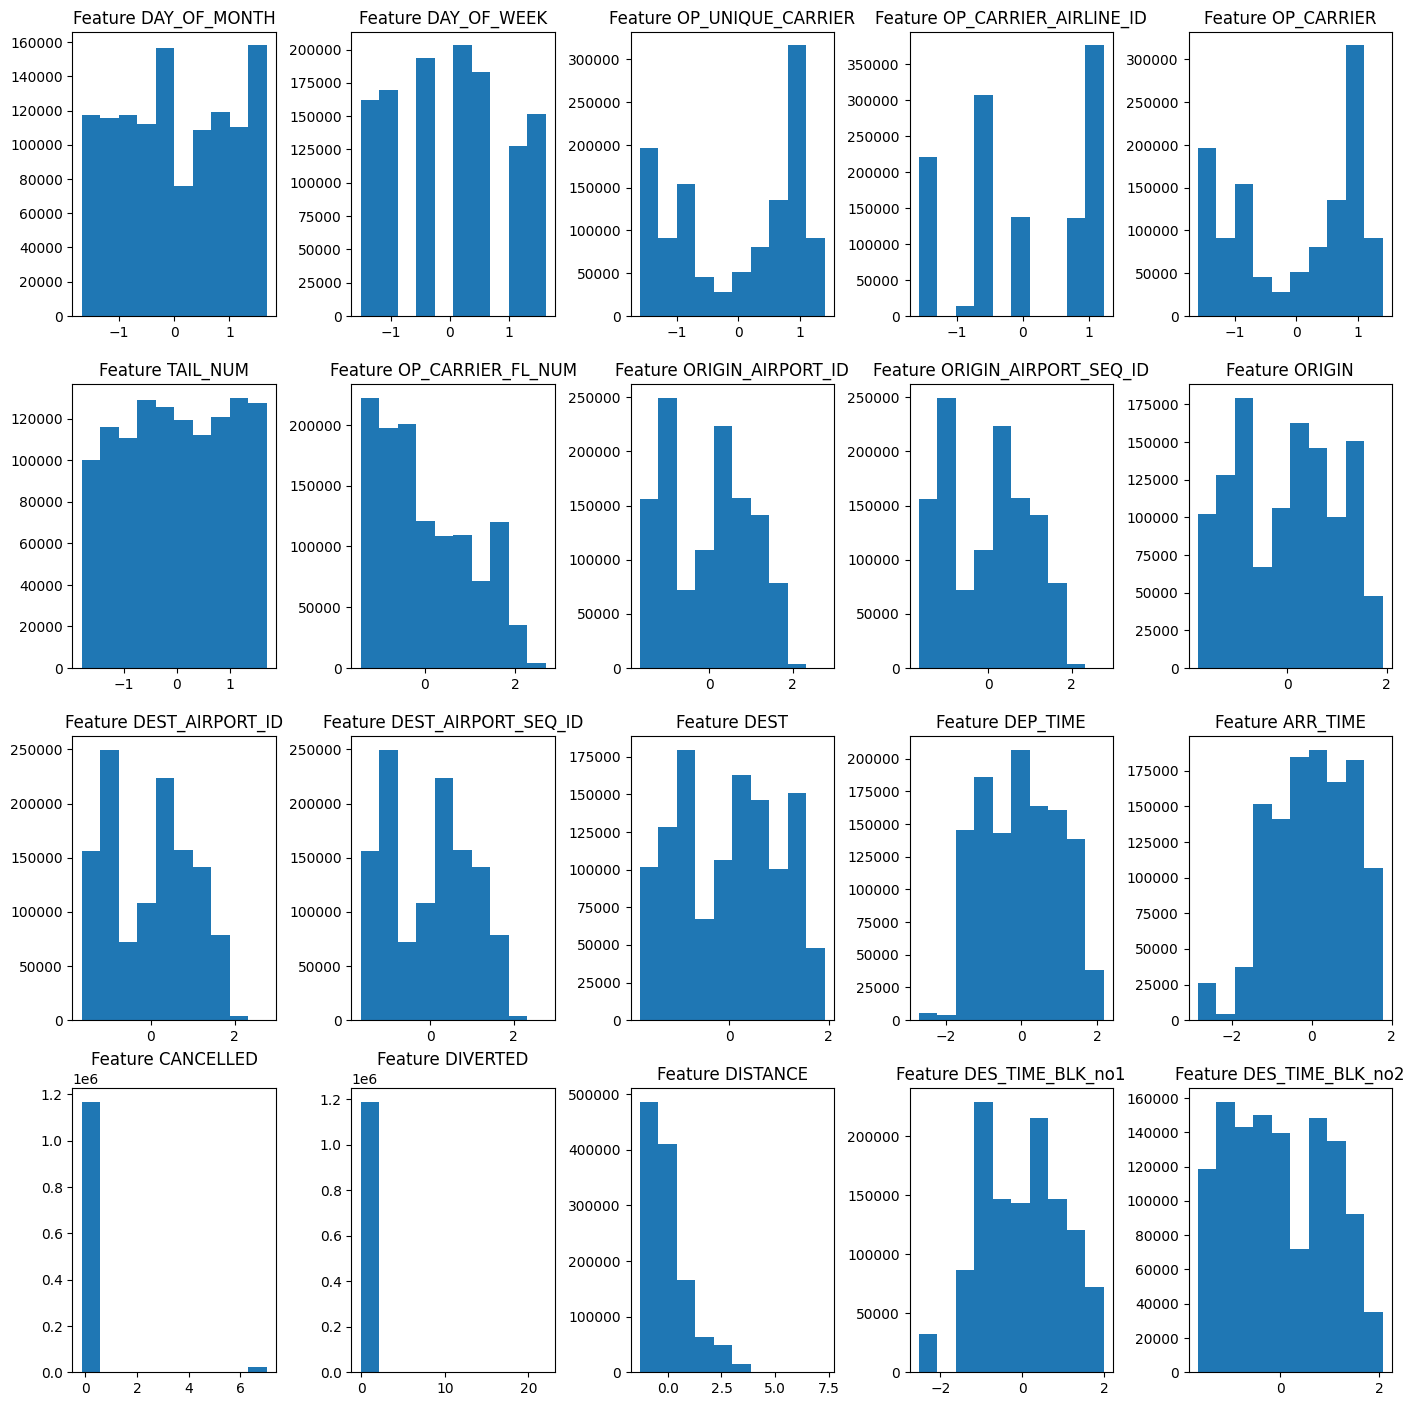

In [157]:
fig, axes = plt.subplots(4, 5, figsize=(14, 14))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.hist(data.iloc[:, i], bins=10)
    ax.set_title(f"Feature {data.columns[i]}")
plt.tight_layout(pad=0.5)
plt.show()

<h4>Labels</h4>

In [16]:
labels

,0
0,0
1,0
2,0
3,0
4,0
...,...
1191326,3
1191327,0
1191328,0
1191329,0


<h4>Normalizing</h4>
<p><b>NOTE:</b> Method is to use standard normalization, that means to transform data to new values with mean of zero and standard deviation of 1</p>

In [24]:
scalar = StandardScaler()
normalized_data = pd.DataFrame(scalar.fit_transform(data), columns=data.columns)
data = normalized_data

<h4>Eliminate high correlated features</h4>
<ul>
    <li>Plot correlation matrix of data</li>
    <li>Recognize high correlated features</li>
    <li>Scale them down to fewer features</li>
</ul>
<p><b>NOTE:</b> This step will improve the final results and also the procedure of learning</p>

<h4>1. Correlation Matrix</h4>

<Axes: >

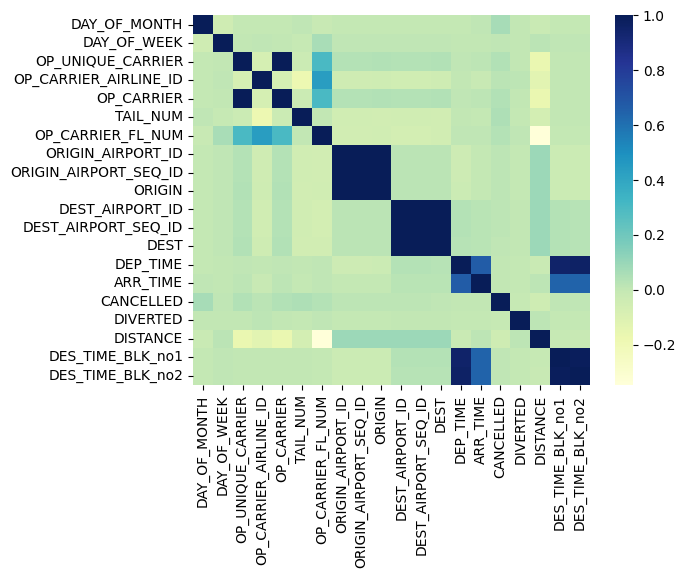

In [25]:
corr_mat = data.corr()
sb.heatmap(corr_mat, cmap='YlGnBu')

<h4>2. Conclusion</h4>
<p>As you can see in the heatmap of correlation matrix, below sets of features are highly correlated</p>
<ul>
    <li>OP_UNIQUE_CARRIER & OP_CARRIER</li>
    <li>ORIGIN_AIRPORT_ID & ORIGIN_AIRPORT_SEQ_ID & ORIGIN</li>
    <li>DEST_AIRPORT_ID & DEST_AIRPORT_SEQ_ID & DEST</li>
    <li>DES_TIME_BLK_no1 & DES_TIME_BLK_no2 & DEP_TIME</li>
</ul>
<p><b>NOTE:</b> Now we need to pick a method to scale down these sets of features, we could use <b>AutoEncoder</b> but shallow autoencoder does not provide good results and the input dimension is 3 or 2 so we can use <b>PCA</b> or <b>LDA</b> instead</p>

<h4>3. Scaling down</h4>
<b>Methods</b>
<ul>
    <li>PCA</li>
    <li>LDA</li>
    <li>AutoEncoderr (<b>on original data</b>, not data that highly correlated features eliminated)</li>
</ul>
<p><b>NOTE:</b> Before scaling down the data we seperate labels from training data</p>

<h5>1. PCA</h5>

In [32]:
# First set of features
pca = PCA(n_components=1)
op_carrier = data[['OP_UNIQUE_CARRIER', 'OP_CARRIER']]
op_carrier_new = pca.fit_transform(op_carrier, labels)
op_carrier_new = pd.DataFrame(op_carrier_new, columns=['OP_CARRIER'])

# Second set of features
pca = PCA(n_components=1)
origin = data[['ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN']]
origin_new = pca.fit_transform(origin, labels)
origin_new = pd.DataFrame(origin_new, columns=['ORIGIN'])

# Third set of features
pca = PCA(n_components=1)
dest = data[['DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST']]
dest_new = pca.fit_transform(dest, labels)
dest_new = pd.DataFrame(dest_new, columns=['DEST'])

# Fourth set of features
pca = PCA(n_components=1)
des = data[['DES_TIME_BLK_no1', 'DES_TIME_BLK_no2', 'DEP_TIME']]
des_new = pca.fit_transform(des, labels)
des_new = pd.DataFrame(des_new, columns=['DES'])

# Concatenate them
pca_data = pd.concat([op_carrier_new, origin_new, dest_new, des_new] , axis=1)

<h4>Data that scaled down via PCA</h4>

In [33]:
pca_data

,OP_CARRIER,ORIGIN,DEST,DES
0,2.263886,-0.779644,-2.636797,2.479787
1,2.263886,0.975596,-1.648770,-0.275485
2,2.263886,-1.375364,-1.648770,0.360309
3,2.263886,2.946540,-2.636797,-0.698264
4,2.263886,-2.636869,-0.961026,-2.014137
...,...,...,...,...
1191326,2.263886,3.137267,-1.375211,1.778488
1191327,2.263886,-1.375364,-0.125045,-1.429618
1191328,2.263886,-0.704354,0.351244,2.534559
1191329,2.263886,-2.636869,3.565163,-1.391161


<h5>2. LDA</h5>

In [35]:
# First set of features
lda = LDA(n_components=1)
op_carrier = data[['OP_UNIQUE_CARRIER', 'OP_CARRIER']]
op_carrier_new = lda.fit_transform(op_carrier, labels)
op_carrier_new = pd.DataFrame(op_carrier_new, columns=['OP_CARRIER'])

# Second set of features
lda = LDA(n_components=1)
origin = data[['ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN']]
origin_new = lda.fit_transform(origin, labels)
origin_new = pd.DataFrame(origin_new, columns=['ORIGIN'])

# Third set of features
lda = LDA(n_components=1)
dest = data[['DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST']]
dest_new = lda.fit_transform(dest, labels)
dest_new = pd.DataFrame(dest_new, columns=['DEST'])

# Fourth set of features
lda = LDA(n_components=1)
des = data[['DES_TIME_BLK_no1', 'DES_TIME_BLK_no2', 'DEP_TIME']]
des_new = lda.fit_transform(des, labels)
des_new = pd.DataFrame(des_new, columns=['DES'])

# Concatenate them
lda_data = pd.concat([op_carrier_new, origin_new, dest_new, des_new], axis=1)

e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_DL_Methods_on_Flight_USA_Dataset\.env\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_DL_Methods_on_Flight_USA_Dataset\.env\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_DL_Methods_on_Flight_USA_Dataset\.env\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

<h4>Data that scaled down via LDA</h4>

In [36]:
lda_data

,OP_CARRIER,ORIGIN,DEST,DES
0,-1.601175,0.032438,-2.145120,-0.990160
1,-1.601175,0.942100,-0.350025,-0.359137
2,-1.601175,-0.287712,-0.350025,-0.217454
3,-1.601175,1.249785,-2.145120,0.162319
4,-1.601175,-2.143385,0.302302,0.129033
...,...,...,...,...
1191326,-1.601175,1.415333,-0.231685,1.104174
1191327,-1.601175,-0.287712,1.308870,0.560284
1191328,-1.601175,0.483319,0.411896,-1.299471
1191329,-1.601175,-2.143385,-1.023127,0.343108


<h4>Concat original data with new data</h4>
<p><b>NOTE:</b> Once data with using PCA and once with LDA</p>

In [37]:
droped_data = data.drop(columns=['OP_UNIQUE_CARRIER', 'OP_CARRIER', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST', 'DES_TIME_BLK_no1', 'DES_TIME_BLK_no2', 'DEP_TIME'])

<h5>1. PCA</h5>
<p>Concat new features with other features left</p>

In [38]:
pca_data_final = pd.concat([droped_data, pca_data], axis=1)

<h5>2. LDA</h5>
<p>Concat new features with other features left</p>

In [39]:
lda_data_final = pd.concat([droped_data, lda_data], axis=1)

<h5>3. AutoEncoder</h5>
<p>Input dimension is 20, we have to fine tune the number of dimensions we want at the end</p>
<p><b>NOTE:</b> I tried about 40 different models with <b>different optimizer</b>, <b>loss functions</b>, <b>bottle neck size</b> and <b>number of layers in hidden layers</b></p>
<ul>
    <li>Optimizers</li>
    <ol>
        <li>Adam</li>
        <li>SGD</li>
        <li>FTRL</li>
        <li>Nadam</li>
        <li>Adamax</li>
        <li>Adagard</li>
    </ol>
    <li>Loss Functions</li>
    <ol>
        <li>MSE</li>
        <li>Binary_CrossEntropy</li>
        <li>Cosine_Similarity</li>
        <li>RMSE</li>
    </ol>
    <li>Bottle Neck size</li>
    <ol>
        <li>10</li>
        <li>8</li>
        <li>6</li>
        <li>5</li>
        <li>4</li>
    </ol>
    <li>Hidden Layers Size</li>
    <ol>
        <li>5</li>
        <li>3</li>
        <li>1</li>
    </ol>
</ul>
<p><b>NOTE:</b> This model is the best model I chose between other models with minimum MSE (you can see other layers which are commented below)</p>

In [123]:
# Input layer
input_layer = Input((20,))

# Encoder
# encoded = Dense(18, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(input_layer)
# encoded = Dense(14, activation='relu')(encoded)
encoded = Dense(12, activation='relu')(encoded)
# encoded = Dense(10, activation='relu')(encoded)
encoded = Dense(8, activation='relu')(encoded)
# encoded = Dense(4, activation='relu')(encoded)


# Decoder
# decoded = Dense(8, activation='relu')(encoded)
# decoded = Dense(10, activation='relu')(decoded)
decoded = Dense(12, activation='relu')(encoded)
# decoded = Dense(14, activation='relu')(decoded)
decoded = Dense(16, activation='relu')(decoded)
# decoded = Dense(18, activation='relu')(decoded)
decoded = Dense(20, activation='sigmoid')(decoded)

# Define autoencoder
autoencoder = Model(input_layer, decoded)

# Compile autoencoder
autoencoder.compile(optimizer='nadam', loss='mse')

# Model summary
autoencoder.summary()


Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 20)]              0         
                                                                 
 dense_166 (Dense)           (None, 16)                336       
                                                                 
 dense_167 (Dense)           (None, 12)                204       
                                                                 
 dense_168 (Dense)           (None, 8)                 104       
                                                                 
 dense_169 (Dense)           (None, 12)                108       
                                                                 
 dense_170 (Dense)           (None, 16)                208       
                                                                 
 dense_171 (Dense)           (None, 20)                340

<h5>Fit Autoencoder</h5>

In [124]:
# Split train and validation data
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)

# Fit autoencoder
log = autoencoder.fit(X_train, X_train, epochs=50, batch_size=512, shuffle=True, validation_data=(X_val, X_val))

Epoch 1/50
1862/1862 [==============================] - 9s 4ms/step - loss: 0.7242 - val_loss: 0.6554
Epoch 2/50
1862/1862 [==============================] - 7s 3ms/step - loss: 0.6470 - val_loss: 0.6370
Epoch 3/50
1862/1862 [==============================] - 8s 4ms/step - loss: 0.6328 - val_loss: 0.6315
Epoch 4/50
1862/1862 [==============================] - 7s 4ms/step - loss: 0.6302 - val_loss: 0.6303
Epoch 5/50
1862/1862 [==============================] - 7s 4ms/step - loss: 0.6294 - val_loss: 0.6298
Epoch 6/50
1862/1862 [==============================] - 7s 4ms/step - loss: 0.6289 - val_loss: 0.6294
Epoch 7/50
1862/1862 [==============================] - 7s 4ms/step - loss: 0.6285 - val_loss: 0.6290
Epoch 8/50
1862/1862 [==============================] - 7s 4ms/step - loss: 0.6282 - val_loss: 0.6286
Epoch 9/50
1862/1862 [==============================] - 6s 3ms/step - loss: 0.6279 - val_loss: 0.6284
Epoch 10/50
1862/1862 [==============================] - 7s 4ms/step - loss: 0.627

<h4>Compare Validation loss & Train loss</h4>

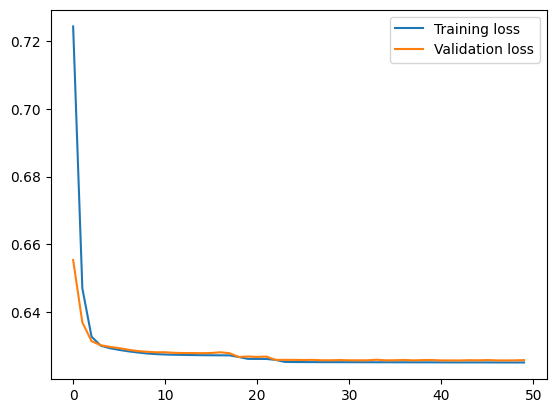

In [125]:
plt.plot(log.history['loss'], label='Training loss')
plt.plot(log.history['val_loss'], label='Validation loss')
plt.legend()


<h4>Encode to scale down the data</h4>

In [130]:
encoder = Model(inputs=autoencoder.input, outputs=encoded)
data_encoder = encoder.predict(data)
data_encoder = pd.DataFrame(data_encoder)

37230/37230 [==============================] - 52s 1ms/step


<h4>Scaled down data using autoencoder</h4>

In [131]:
data_encoder

,0,1,2,3,4,5,6,7
0,12.892561,11.528049,10.748754,18.942413,8.099140,5.552902,6.297283,12.785864
1,8.255295,12.690526,9.971931,17.653433,6.975260,7.381440,9.082417,9.176686
2,12.276353,11.040034,8.781039,18.155930,8.814411,5.464913,5.451687,9.744968
3,5.960572,12.084159,8.800099,16.375406,3.471491,6.357400,6.629974,8.157006
4,12.391042,12.995276,8.767003,15.981238,9.305572,5.596599,4.973202,4.962887
...,...,...,...,...,...,...,...,...
1191326,9.348047,6.961815,13.618443,22.791872,7.189579,10.027761,9.271857,13.678680
1191327,13.466393,11.036309,14.304313,19.610535,10.849542,9.760435,8.466968,6.097364
1191328,14.533559,7.825894,16.648478,23.700403,12.754671,9.910595,8.313114,14.975790
1191329,13.220089,11.135524,16.872173,20.132891,15.981547,10.446181,7.023074,6.794665


<h4>Seprate Train & Test data on PCA, LDA, AutoEncoder</h4>

1. PCA

In [189]:
X_pca_train, X_pca_test, y_pca_Train, y_pca_test = train_test_split(pca_data, labels, test_size=0.2, random_state=42, shuffle=True)

2. LDA

In [190]:
X_lda_train, X_lda_test, y_lda_train, y_lda_test = train_test_split(lda_data, labels, test_size=0.2, random_state=42, shuffle=True)

3. AutoEncoder

In [191]:
X_auto_train, X_auto_test, y_auto_train, y_auto_test = train_test_split(data_encoder, labels, test_size=0.2, random_state=42, shuffle=True)

<h4>Classifiers</h4>
<ul>
    <li>MLP</li>
    <li>ELM</li>
    <li>Decision Tree (just for comparing)</li>
</ul>
<p><b>NOTE:</b> I tried all 3 ways of scaling down on these three classifiers</p>

<h3>1. MLP</h3>
<p><b>NOTE:</b> As you can see the fitting time on this dataset took about 20 mins per model and because of that I did not used Gridsearch for fine tuning and changed hyperparameters manually and find the best model and applied it on all three scaled down data. You can see the best model in below section</p>

1.1. MLP with PCA

In [192]:
mlp_pca = MLPClassifier(random_state=42, hidden_layer_sizes=(50, 100, 200, 100, 50), solver='adam', learning_rate='adaptive', alpha=0.001, activation='relu', max_iter=10)
mlp_pca.fit(X_pca_train, y_pca_Train)

e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_DL_Methods_on_Flight_USA_Dataset\.env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_DL_Methods_on_Flight_USA_Dataset\.env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.001, hidden_layer_sizes=(50, 100, 200, 100, 50),
              learning_rate='adaptive', max_iter=10, random_state=42)

Prediction of MLP on PCA results

In [193]:
# Test data prediction
pred_mlp_pca_test = mlp_pca.predict(X_pca_test)

# Train data prediction
pred_mlp_pca_train = mlp_pca.predict(X_pca_train)

Results of MLP on PCA scaled down data

In [211]:
# Test data
acc_mlp_pca_test = accuracy_score(y_pca_test, pred_mlp_pca_test)
prec_mlp_pca_test = precision_score(y_pca_test, pred_mlp_pca_test, average='weighted')
rec_mlp_pca_test = recall_score(y_pca_test, pred_mlp_pca_test, average='weighted')
f1_mlp_pca_test = f1_score(y_pca_test, pred_mlp_pca_test, average='weighted')
con_mat_mlp_pca_test = confusion_matrix(y_pca_test, pred_mlp_pca_test)

# Train data
acc_mlp_pca_train = accuracy_score(y_pca_Train, pred_mlp_pca_train)
prec_mlp_pca_train = precision_score(y_pca_Train, pred_mlp_pca_train, average='weighted')
rec_mlp_pca_train = recall_score(y_pca_Train, pred_mlp_pca_train, average='weighted')
f1_mlp_pca_train = f1_score(y_pca_Train, pred_mlp_pca_train, average='weighted')
con_mat_mlp_pca_train = confusion_matrix(y_pca_Train, pred_mlp_pca_train)

e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_DL_Methods_on_Flight_USA_Dataset\.env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_DL_Methods_on_Flight_USA_Dataset\.env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h4>Visualize the results</h4>

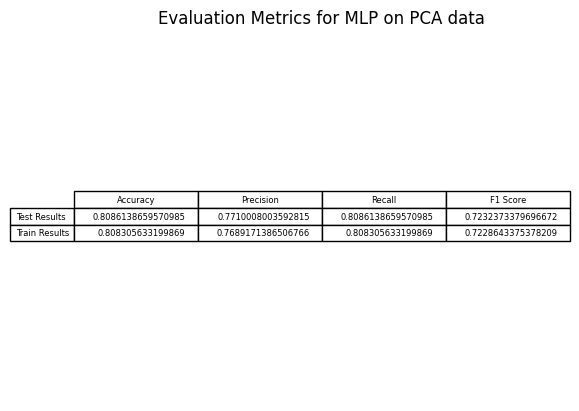

<Figure size 1000x1000 with 0 Axes>

In [212]:
plt.table([[acc_mlp_pca_test, prec_mlp_pca_test, rec_mlp_pca_test, f1_mlp_pca_test], [acc_mlp_pca_train, prec_mlp_pca_train, rec_mlp_pca_train, f1_mlp_pca_train]], colLabels=['Accuracy', 'Precision', 'Recall', 'F1 Score'], rowLabels=['Test Results', 'Train Results'], loc='center')
plt.axis('off')
plt.title("Evaluation Metrics for MLP on PCA data")
plt.figure(figsize=(10,10))
plt.show()

<h4>Confusion Matrix of MLP on PCA scaled down data (test results)</h4>

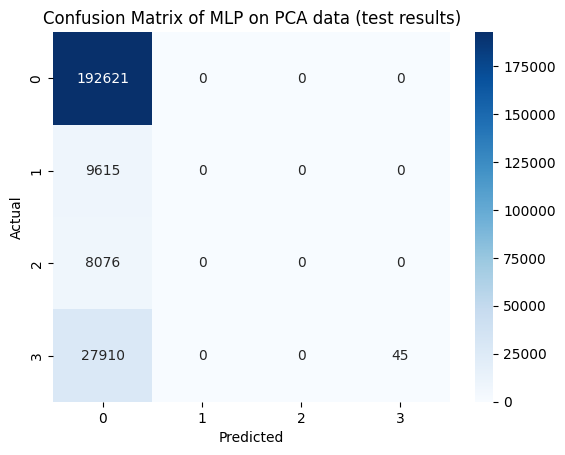

In [196]:
sb.heatmap(con_mat_mlp_pca_test, annot=True, fmt='d', cmap='Blues')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix of MLP on PCA data (test results)")
plt.show()

<h4>Confusion Matrix of MLP on PCA scaled down data (train results)</h4>

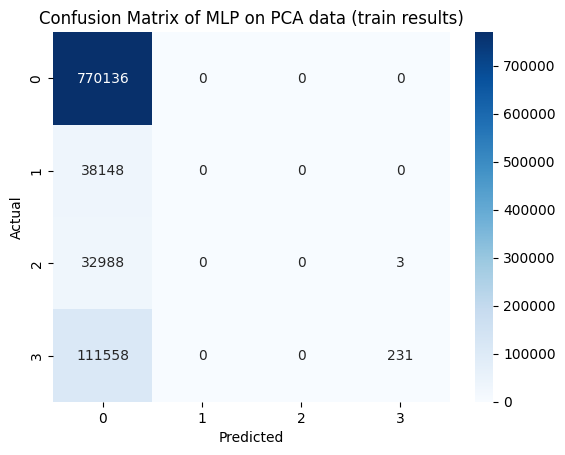

In [198]:
sb.heatmap(con_mat_mlp_pca_train, annot=True, fmt='d', cmap='Blues')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix of MLP on PCA data (train results)")
plt.show()

1.2. MLP with LDA

In [199]:
mlp_lda = MLPClassifier(random_state=42, hidden_layer_sizes=(50, 100, 200, 100, 50), solver='adam', learning_rate='adaptive', alpha=0.001, activation='relu', max_iter=10)
mlp_lda.fit(X_lda_train, y_lda_train)

e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_DL_Methods_on_Flight_USA_Dataset\.env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_DL_Methods_on_Flight_USA_Dataset\.env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.001, hidden_layer_sizes=(50, 100, 200, 100, 50),
              learning_rate='adaptive', max_iter=10, random_state=42)

Prediction of MLP on LDA results

In [200]:
# Test data prediction
pred_mlp_lda_test = mlp_lda.predict(X_lda_test)

# Train data prediction
pred_mlp_lda_train = mlp_lda.predict(X_lda_train)

Results of MLP on LDA scaled down data

In [201]:
# Test data
acc_mlp_lda_test = accuracy_score(y_lda_test, pred_mlp_lda_test)
prec_mlp_lda_test = precision_score(y_lda_test, pred_mlp_lda_test, average='weighted')
rec_mlp_lda_test = recall_score(y_lda_test, pred_mlp_lda_test, average='weighted')
f1_mlp_lda_test = f1_score(y_lda_test, pred_mlp_lda_test, average='weighted')
con_mat_mlp_lda_test = confusion_matrix(y_lda_test, pred_mlp_lda_test)

# Train data
acc_mlp_lda_train = accuracy_score(y_lda_train, pred_mlp_lda_train)
prec_mlp_lda_train = precision_score(y_lda_train, pred_mlp_lda_train, average='weighted')
rec_mlp_lda_train = recall_score(y_lda_train, pred_mlp_lda_train, average='weighted')
f1_mlp_lda_train = f1_score(y_lda_train, pred_mlp_lda_train, average='weighted')
con_mat_mlp_lda_train = confusion_matrix(y_lda_train, pred_mlp_lda_train)

e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_DL_Methods_on_Flight_USA_Dataset\.env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_DL_Methods_on_Flight_USA_Dataset\.env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h4>Visualize the results</h4>

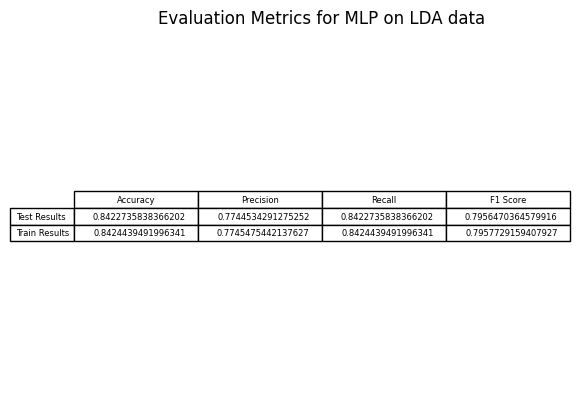

<Figure size 1000x1000 with 0 Axes>

In [202]:
plt.table([[acc_mlp_lda_test, prec_mlp_lda_test, rec_mlp_lda_test, f1_mlp_lda_test], [acc_mlp_lda_train, prec_mlp_lda_train, rec_mlp_lda_train, f1_mlp_lda_train]], colLabels=['Accuracy', 'Precision', 'Recall', 'F1 Score'], rowLabels=['Test Results', 'Train Results'], loc='center')
plt.axis('off')
plt.title("Evaluation Metrics for MLP on LDA data")
plt.figure(figsize=(10,10))
plt.show()

<h4>Confusion Matrix of MLP on LDA scaled down data (test results)</h4>

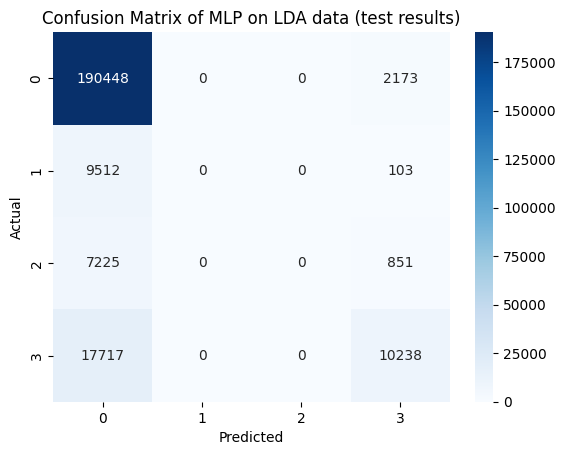

In [203]:
sb.heatmap(con_mat_mlp_lda_test, annot=True, fmt='d', cmap='Blues')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix of MLP on LDA data (test results)")
plt.show()

<h4>Confusion Matrix of MLP on LDA scaled down data (train results)</h4>

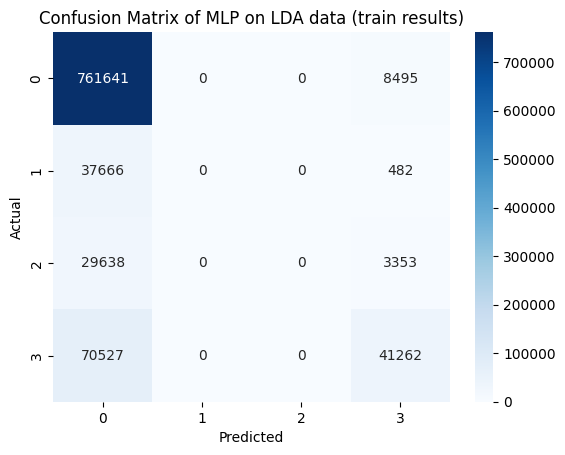

In [204]:
sb.heatmap(con_mat_mlp_lda_train, annot=True, fmt='d', cmap='Blues')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix of MLP on LDA data (train results)")
plt.show()

1.3. MLP with Autoencoder

In [205]:
mlp_auto = MLPClassifier(random_state=42, hidden_layer_sizes=(50, 100, 200, 100, 50), solver='adam', learning_rate='adaptive', alpha=0.001, activation='relu', max_iter=10)
mlp_auto.fit(X_auto_train, y_auto_train)

e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_DL_Methods_on_Flight_USA_Dataset\.env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_DL_Methods_on_Flight_USA_Dataset\.env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.001, hidden_layer_sizes=(50, 100, 200, 100, 50),
              learning_rate='adaptive', max_iter=10, random_state=42)

Prediction of MLP on AutoEncoder results

In [206]:
# Test data prediction
pred_mlp_auto_test = mlp_auto.predict(X_auto_test)

# Train data prediction
pred_mlp_auto_train = mlp_auto.predict(X_auto_train)


Results of MLP on AutoEncoder scaled down data

In [207]:
# Test data
acc_mlp_auto_test = accuracy_score(y_auto_test, pred_mlp_auto_test)
prec_mlp_auto_test = precision_score(y_auto_test, pred_mlp_auto_test, average='weighted')
rec_mlp_auto_test = recall_score(y_auto_test, pred_mlp_auto_test, average='weighted')
f1_mlp_auto_test = f1_score(y_auto_test, pred_mlp_auto_test, average='weighted')
con_mat_mlp_auto_test = confusion_matrix(y_auto_test, pred_mlp_auto_test)

# Train data
acc_mlp_auto_train = accuracy_score(y_auto_train, pred_mlp_auto_train)
prec_mlp_auto_train = precision_score(y_auto_train, pred_mlp_auto_train, average='weighted')
rec_mlp_auto_train = recall_score(y_auto_train, pred_mlp_auto_train, average='weighted')
f1_mlp_auto_train = f1_score(y_auto_train, pred_mlp_auto_train, average='weighted')
con_mat_mlp_auto_train = confusion_matrix(y_auto_train, pred_mlp_auto_train)

e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_DL_Methods_on_Flight_USA_Dataset\.env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_DL_Methods_on_Flight_USA_Dataset\.env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h4>Visualize the results</h4>

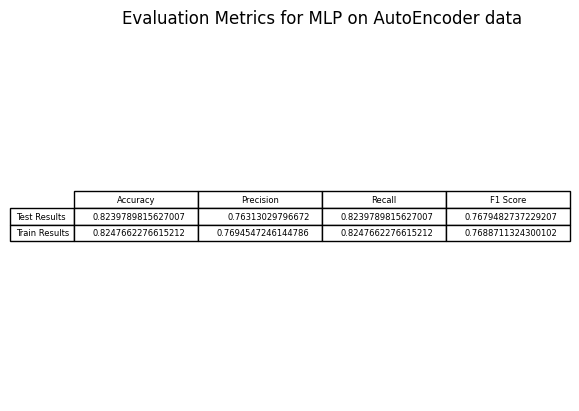

<Figure size 1000x1000 with 0 Axes>

In [208]:
plt.table([[acc_mlp_auto_test, prec_mlp_auto_test, rec_mlp_auto_test, f1_mlp_auto_test], [acc_mlp_auto_train, prec_mlp_auto_train, rec_mlp_auto_train, f1_mlp_auto_train]], colLabels=['Accuracy', 'Precision', 'Recall', 'F1 Score'], rowLabels=['Test Results', 'Train Results'], loc='center')
plt.axis('off')
plt.title("Evaluation Metrics for MLP on AutoEncoder data")
plt.figure(figsize=(10,10))
plt.show()

<h4>Confusion Matrix of MLP on AutoEncoder scaled down data (test results)</h4>

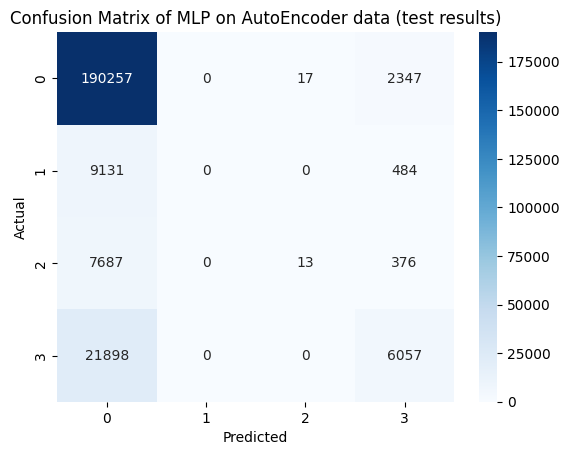

In [209]:
sb.heatmap(con_mat_mlp_auto_test, annot=True, fmt='d', cmap='Blues')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix of MLP on AutoEncoder data (test results)")
plt.show()

<h4>Confusion Matrix of MLP on AutoEncoder scaled down data (train results)</h4>

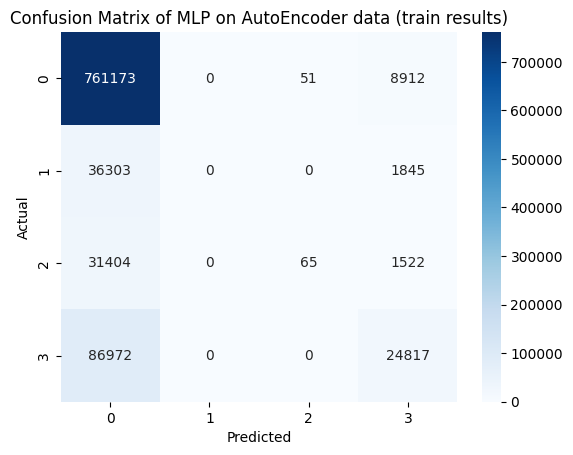

In [210]:
sb.heatmap(con_mat_mlp_auto_train, annot=True, fmt='d', cmap='Blues')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix of MLP on AutoEncoder data (train results)")
plt.show()

<p><b>NOTE:</b> This package need only works on binary classes, so we need to use one-hot encoding before fitting</p>

In [222]:
# PCA data
encoder = OneHotEncoder(sparse=False)
y_pca_Train_coded = encoder.fit_transform(np.array(y_pca_Train).reshape(-1, 1))
y_pca_test_coded = encoder.transform(np.array(y_pca_test).reshape(-1, 1))

# LDA data
encoder = OneHotEncoder(sparse=False)
y_lda_train_coded = encoder.fit_transform(np.array(y_lda_train).reshape(-1, 1))
y_lda_test_coded = encoder.transform(np.array(y_lda_test).reshape(-1, 1))

# AutoEncoder data
encoder = OneHotEncoder(sparse=False)
y_auto_train_coded = encoder.fit_transform(np.array(y_auto_train).reshape(-1, 1))
y_auto_test_coded = encoder.transform(np.array(y_auto_test).reshape(-1, 1))

e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_DL_Methods_on_Flight_USA_Dataset\.env\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_DL_Methods_on_Flight_USA_Dataset\.env\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_DL_Methods_on_Flight_USA_Dataset\.env\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unl

2.1. ELM with PCA

In [224]:
elm_pca = ELM(np.array(X_pca_train).shape[1], np.array(y_pca_Train_coded).shape[1])
elm_pca.add_neurons(30, 'sigm')
elm_pca.train(np.array(X_pca_train) , np.array(y_pca_Train_coded))

Prediction of ELM on PCA results

In [229]:
# Test data prediction
elm_pca_pred_test = elm_pca.predict(np.array(X_pca_test))
elm_pca_pred_test = np.argmax(np.array(elm_pca_pred_test), axis=1)

# Train data prediction
elm_pca_pred_train = elm_pca.predict(np.array(X_pca_train))
elm_pca_pred_train = np.argmax(np.array(elm_pca_pred_train), axis=1)

Results of EML on PCA scaled down data

In [236]:
# Test data
acc_elm_pca_test = accuracy_score(y_pca_test, elm_pca_pred_test)
prec_elm_pca_test = precision_score(y_pca_test, elm_pca_pred_test, average='weighted')
rec_elm_pca_test = recall_score(y_pca_test, elm_pca_pred_test, average='weighted')
f1_elm_pca_test = f1_score(y_pca_test, elm_pca_pred_test, average='weighted')
con_mat_elm_pca_test = confusion_matrix(y_pca_test, elm_pca_pred_test)

# Train data
acc_elm_pca_train = accuracy_score(y_pca_Train, elm_pca_pred_train)
prec_elm_pca_train = precision_score(y_pca_Train, elm_pca_pred_train, average='weighted')
rec_elm_pca_train = recall_score(y_pca_Train, elm_pca_pred_train, average='weighted')
f1_elm_pca_train = f1_score(y_pca_Train, elm_pca_pred_train, average='weighted')
con_mat_elm_pca_train = confusion_matrix(y_pca_Train, elm_pca_pred_train)

e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_DL_Methods_on_Flight_USA_Dataset\.env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_DL_Methods_on_Flight_USA_Dataset\.env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h4>Visualize the results</h4>

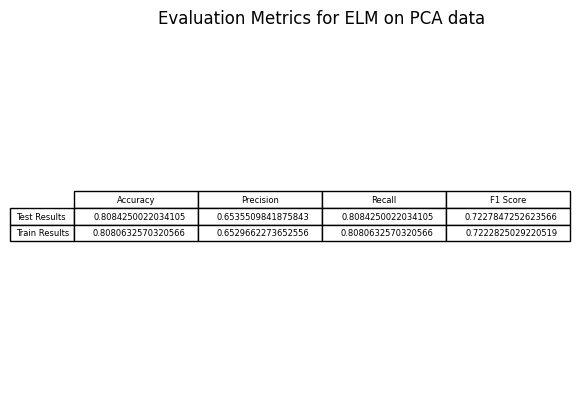

<Figure size 1000x1000 with 0 Axes>

In [237]:
plt.table([[acc_elm_pca_test, prec_elm_pca_test, rec_elm_pca_test, f1_elm_pca_test], [acc_elm_pca_train, prec_elm_pca_train, rec_elm_pca_train, f1_elm_pca_train]], colLabels=['Accuracy', 'Precision', 'Recall', 'F1 Score'], rowLabels=['Test Results', 'Train Results'], loc='center')
plt.axis('off')
plt.title("Evaluation Metrics for ELM on PCA data")
plt.figure(figsize=(10,10))
plt.show()

<h4>Confusion Matrix of ELM on PCA scaled down data (test results)</h4>

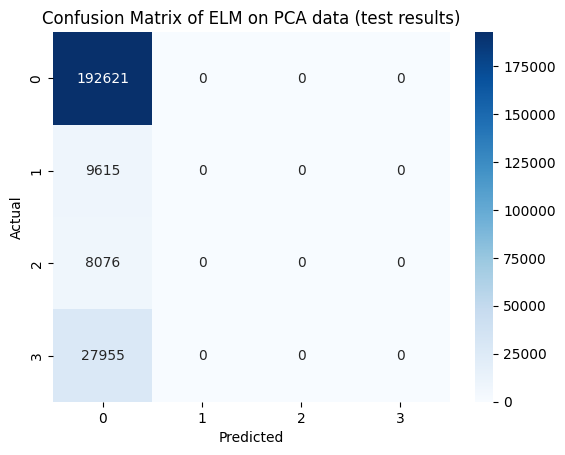

In [238]:
sb.heatmap(con_mat_elm_pca_test, annot=True, fmt='d', cmap='Blues')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix of ELM on PCA data (test results)")
plt.show()

<h4>Confusion Matrix of ELM on PCA scaled down data (train results)</h4>

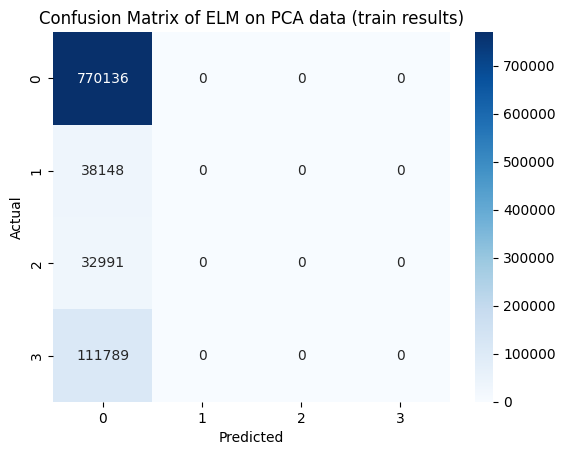

In [239]:
sb.heatmap(con_mat_elm_pca_train, annot=True, fmt='d', cmap='Blues')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix of ELM on PCA data (train results)")
plt.show()

2.2. ELM with LDA

In [234]:
elm_lda = ELM(np.array(X_lda_train).shape[1], np.array(y_lda_train_coded).shape[1])
elm_lda.add_neurons(30, 'sigm')
elm_lda.train(np.array(X_lda_train) , np.array(y_lda_train_coded))

Prediction of ELM on LDA results

In [235]:
# Test data prediction
elm_lda_pred_test = elm_lda.predict(np.array(X_lda_test))
elm_lda_pred_test = np.argmax(np.array(elm_lda_pred_test), axis=1)

# Train data prediction
elm_lda_pred_train = elm_lda.predict(np.array(X_lda_train))
elm_lda_pred_train = np.argmax(np.array(elm_lda_pred_train), axis=1)

Results of EML on LDA scaled down data

In [242]:
# Test data
acc_elm_lda_test = accuracy_score(y_lda_test, elm_lda_pred_test)
prec_elm_lda_test = precision_score(y_lda_test, elm_lda_pred_test, average='weighted')
rec_elm_lda_test = recall_score(y_lda_test, elm_lda_pred_test, average='weighted')
f1_elm_lda_test = f1_score(y_lda_test, elm_lda_pred_test, average='weighted')
con_mat_elm_lda_test = confusion_matrix(y_lda_test, elm_lda_pred_test)

# Train data
acc_elm_lda_train = accuracy_score(y_lda_train, elm_lda_pred_train)
prec_elm_lda_train = precision_score(y_lda_train, elm_lda_pred_train, average='weighted')
rec_elm_lda_train = recall_score(y_lda_train, elm_lda_pred_train, average='weighted')
f1_elm_lda_train = f1_score(y_lda_train, elm_lda_pred_train, average='weighted')
con_mat_elm_lda_train = confusion_matrix(y_lda_train, elm_lda_pred_train)

e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_DL_Methods_on_Flight_USA_Dataset\.env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_DL_Methods_on_Flight_USA_Dataset\.env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h4>Visualize the results</h4>

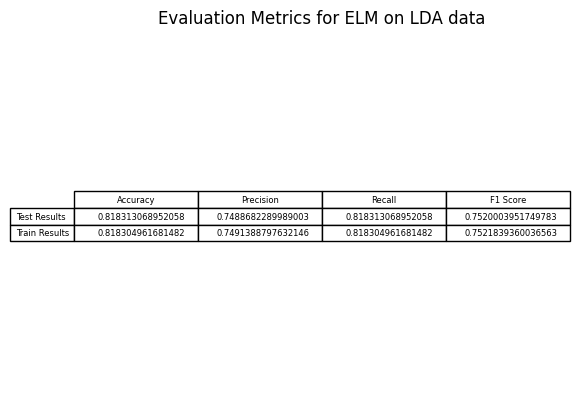

<Figure size 1000x1000 with 0 Axes>

In [243]:
plt.table([[acc_elm_lda_test, prec_elm_lda_test, rec_elm_lda_test, f1_elm_lda_test], [acc_elm_lda_train, prec_elm_lda_train, rec_elm_lda_train, f1_elm_lda_train]], colLabels=['Accuracy', 'Precision', 'Recall', 'F1 Score'], rowLabels=['Test Results', 'Train Results'], loc='center')
plt.axis('off')
plt.title("Evaluation Metrics for ELM on LDA data")
plt.figure(figsize=(10,10))
plt.show()

<h4>Confusion Matrix of ELM on LCA scaled down data (test results)</h4>

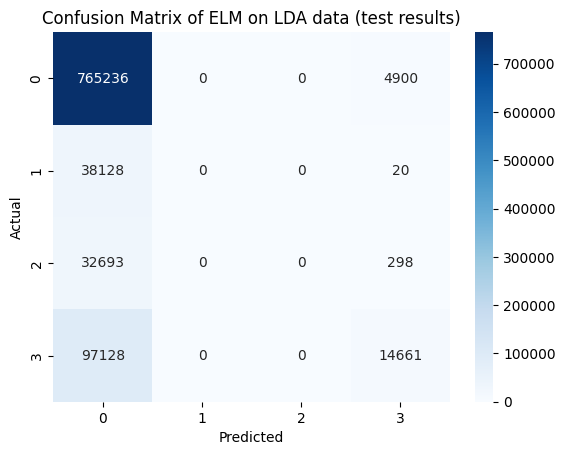

In [244]:
sb.heatmap(con_mat_elm_lda_train, annot=True, fmt='d', cmap='Blues')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix of ELM on LDA data (test results)")
plt.show()

<h4>Confusion Matrix of ELM on LDA scaled down data (train results)</h4>

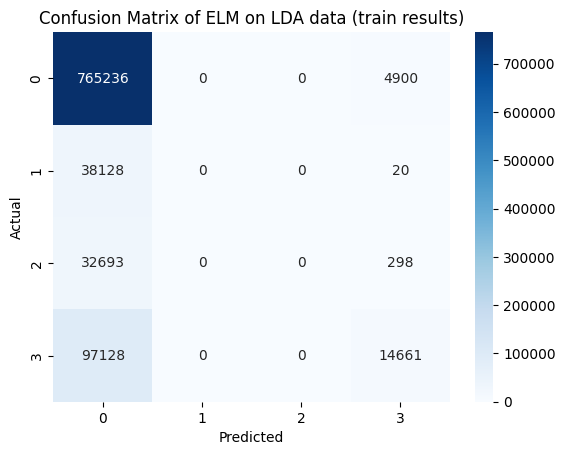

In [245]:
sb.heatmap(con_mat_elm_lda_train, annot=True, fmt='d', cmap='Blues')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix of ELM on LDA data (train results)")
plt.show()

2.3. ELM with Autoencoder

In [ ]:
elm_auto = ELMClassifier(batch_size=128, random_state=42, alpha=0.001)
elm_auto.fit(data_encoder, labels)